<a href="https://colab.research.google.com/github/C0mRD/Walmart-Sales-Analysis/blob/main/Walmart_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()

from sklearn import model_selection
from sklearn import metrics, ensemble, linear_model
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load data

In [ ]:
%cd '/content/drive/MyDrive/walmart-recruiting-store-sales-forecastingv1'

/content/drive/MyDrive/walmart-recruiting-store-sales-forecastingv1


In [ ]:
features = pd.read_csv("features.csv.zip")
stores = pd.read_csv("stores.csv")
train = pd.read_csv("train.csv.zip")
test = pd.read_csv("test.csv.zip")

In [ ]:
features.head()

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False

In [ ]:
stores.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

In [ ]:
train.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

In [ ]:
features.max()

Store                   45
Date            2013-07-26
Temperature         101.95
Fuel_Price           4.468
MarkDown1        103184.98
MarkDown2        104519.54
MarkDown3        149483.31
MarkDown4         67474.85
MarkDown5         771448.1
CPI             228.976456
Unemployment        14.313
IsHoliday             True
dtype: object

In [ ]:
features.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
dtype: object

In [ ]:
feature_store = features.merge(stores, how='inner', on='Store')

In [ ]:
# Converting date column to datetime
feature_store['Date'] = pd.to_datetime(feature_store['Date'])
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Adding some basic datetime features
feature_store['Day'] = feature_store['Date'].dt.day
feature_store['Week'] = feature_store['Date'].dt.week
feature_store['Month'] = feature_store['Date'].dt.month
feature_store['Year'] = feature_store['Date'].dt.year

In [ ]:
train_df = train.merge(feature_store, how='inner', on=['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [ ]:
test_df = test.merge(feature_store, how='inner', on=['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [ ]:
train_df.shape

(421570, 20)

In [ ]:
train_df.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment Type    Size  Day  Week  Month  Year  
0         8.106    A  151315    5     5      2  2010  
1         8.106    A  151315   12     6      2  2010  
2         8.106    A  151315   19     7      2  2010  
3         8.106    A  151315   26     8      2  2010  
4         8.106    A  151315    5     9      3  2010

# Exploratory Data Analysis(EDA)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [ ]:
train_df.nunique()

Store               45
Dept                81
Date               143
Weekly_Sales    359464
IsHoliday            2
Temperature       3528
Fuel_Price         892
MarkDown1         2277
MarkDown2         1499
MarkDown3         1662
MarkDown4         1944
MarkDown5         2293
CPI               2145
Unemployment       349
Type                 3
Size                40
Day                 31
Week                52
Month               12
Year                 3
dtype: int64

In [ ]:
train_df.describe()

Store           Dept   Weekly_Sales    Temperature  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       22.200546      44.260317   15981.258123      60.090059   
std        12.785297      30.492054   22711.183519      18.447931   
min         1.000000       1.000000   -4988.940000      -2.060000   
25%        11.000000      18.000000    2079.650000      46.680000   
50%        22.000000      37.000000    7612.030000      62.090000   
75%        33.000000      74.000000   20205.852500      74.280000   
max        45.000000      99.000000  693099.360000     100.140000   

          Fuel_Price      MarkDown1      MarkDown2      MarkDown3  \
count  421570.000000  150681.000000  111248.000000  137091.000000   
mean        3.361027    7246.420196    3334.628621    1439.421384   
std         0.458515    8291.221345    9475.357325    9623.078290   
min         2.472000       0.270000    -265.760000     -29.100000   
25%         2.933000    2240.270000      41.600000       5.080000   
50%         3.452000    5347.450000     192.000000      24.600000   
75%         3.738000    9210.900000    1926.940000     103.990000   
max         4.468000   88646.760000  104519.540000  141630.610000   

           MarkDown4      MarkDown5            CPI   Unemployment  \
count  134967.000000  151432.000000  421570.000000  421570.000000   
mean     3383.168256    4628.975079     171.201947       7.960289   
std      6292.384031    5962.887455      39.159276       1.863296   
min         0.220000     135.160000     126.064000       3.879000   
25%       504.220000    1878.440000     132.022667       6.891000   
50%      1481.310000    3359.450000     182.318780       7.866000   
75%      3595.040000    5563.800000     212.416993       8.572000   
max     67474.850000  108519.280000     227.232807      14.313000   

                Size            Day           Week          Month  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean   136727.915739      15.673131      25.826762       6.449510   
std     60980.583328       8.753549      14.151887       3.243217   
min     34875.000000       1.000000       1.000000       1.000000   
25%     93638.000000       8.000000      14.000000       4.000000   
50%    140167.000000      16.000000      26.000000       6.000000   
75%    202505.000000      23.000000      38.000000       9.000000   
max    219622.000000      31.000000      52.000000      12.000000   

                Year  
count  421570.000000  
mean     2010.968591  
std         0.796876  
min      2010.000000  
25%      2010.000000  
50%      2011.000000  
75%      2012.000000  
max      2012.000000

## Basic Sales analysis

In [ ]:
df_weeks = train_df.groupby('Week').sum(numeric_only=True)

In [ ]:
plot = px.line( data_frame = df_weeks, x = df_weeks.index, y = 'Weekly_Sales',
                labels = {'Weekly_Sales' : 'Weekly Sales', 'x' : 'Weeks' },
                title = 'Sales over weeks')
plot.show(renderer='colab')

**Mean sales comparassion across the years**

In [ ]:
weekly_sales = train_df.groupby(['Year','Week'], as_index = False).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2010 = train_df.loc[train_df['Year']==2010].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2011 = train_df.loc[train_df['Year']==2011].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2012 = train_df.loc[train_df['Year']==2012].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = weekly_sales2010['Weekly_Sales']['mean'].index, y = weekly_sales2010['Weekly_Sales']['mean'], name = 'Mean Sales 2010', mode = 'lines') )
fig.add_trace(go.Scatter( x = weekly_sales2011['Weekly_Sales']['mean'].index, y = weekly_sales2011['Weekly_Sales']['mean'], name = 'Mean Sales 2011', mode = 'lines') )
fig.add_trace(go.Scatter( x = weekly_sales2012['Weekly_Sales']['mean'].index, y = weekly_sales2012['Weekly_Sales']['mean'], name = 'Mean Sales 2012', mode = 'lines') )
fig.add_annotation(text="Thanksgiving", x=47, y=25000, showarrow=False)
fig.add_annotation(text="Christmas", x=51, y=29000, showarrow=False)
fig.update_layout(title = 'Sales 2010, 2011, 2012', xaxis_title = 'Weeks')
fig.show(renderer='colab')

## Feature Engineering

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown1'], name = 'MarkDown1', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown2'], name = 'MarkDown2', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown3'], name = 'MarkDown3', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown4'], name = 'MarkDown4', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown5'], name = 'MarkDown5', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['Weekly_Sales'], name = 'Weekly Sales', mode = 'lines') )
fig.update_layout(title = "Sales vs Markdown's", xaxis_title = 'Weeks')
fig.show(renderer="colab")

In [ ]:
train_plt = train_df.sample(frac=0.20)

In [ ]:
sizes = train_plt.groupby("Size").mean(numeric_only=True)
plot = px.line(data_frame = sizes, x = sizes.index, y = 'Weekly_Sales', title="Store size vs Sales")
plot.show(renderer='colab')

In [ ]:
store_sales = train_plt.groupby("Type").mean(numeric_only=True)
plot = px.histogram(data_frame=store_sales, x=store_sales.index, y='Weekly_Sales', title="Store type vs Sales")
plot.show(renderer='colab')

In [ ]:
depts= train_plt.groupby('Dept').mean(numeric_only=True).sort_values(by='Weekly_Sales', ascending=False)
bar=px.bar(depts, x = depts.index, y = depts.Weekly_Sales, title='Departament and sales',color=depts.Weekly_Sales)
bar.show(renderer='colab')

In [ ]:
plot = px.histogram(train_plt, x='CPI', y ='Weekly_Sales', color='IsHoliday', marginal='box', opacity= 0.8,
             title='CPI and sales by holiday')
plot.show(renderer='colab')

## Correlation

**Correlation between Features**

<Axes: >

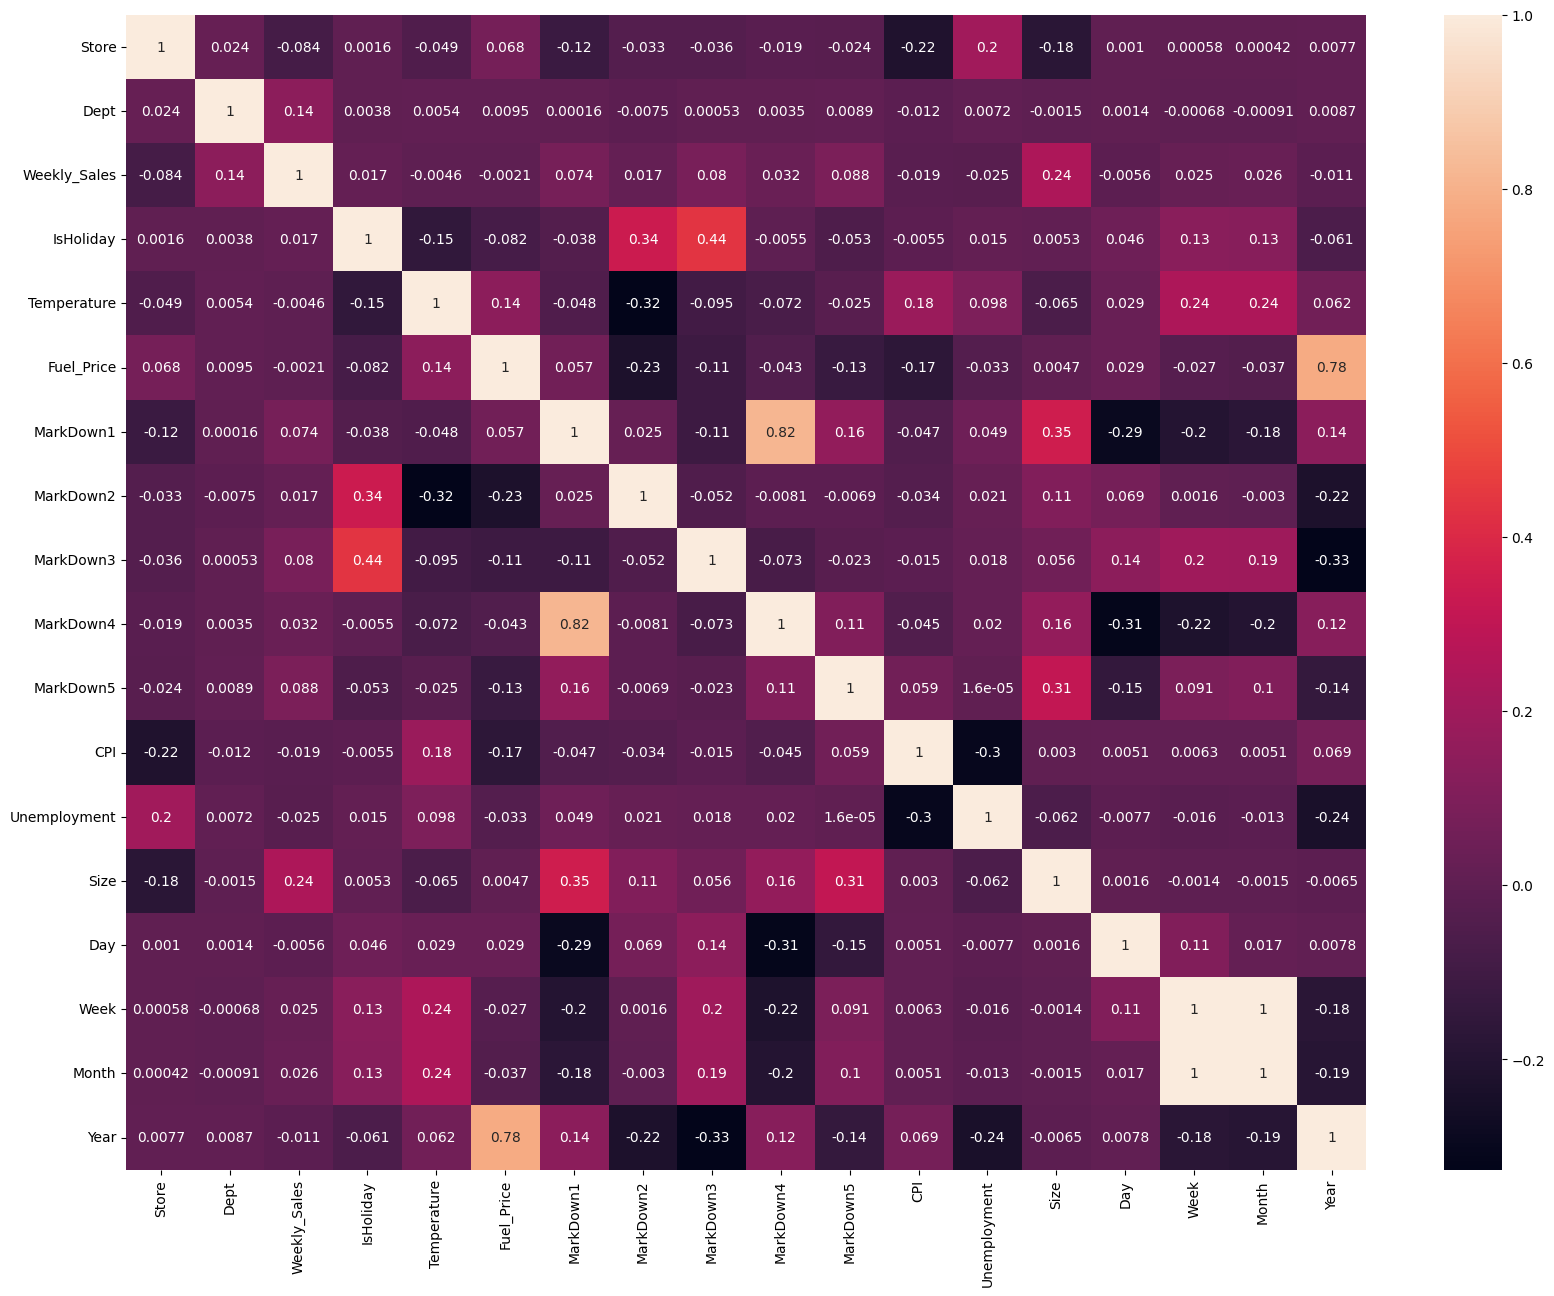

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(train_plt.corr(numeric_only=True), annot=True)

In [ ]:
weekly_sales_corr = train_df.corr(numeric_only=True).iloc[2,:]
corr_df = pd.DataFrame(data = weekly_sales_corr, index = weekly_sales_corr.index ).sort_values (by = 'Weekly_Sales', ascending = False)
corr_df = corr_df.iloc[1:]
bar = px.bar(corr_df, x = corr_df.index, y = 'Weekly_Sales', color=corr_df.index, labels={'index':'Featues'},
             title='Feature correlation with sales')
bar.show(renderer='colab')

# Preprocessing

## Filling missing values

In [ ]:
train_df.isna().sum()[train_df.isna().sum() > 0].sort_values(ascending=True)

MarkDown5    270138
MarkDown1    270889
MarkDown3    284479
MarkDown4    286603
MarkDown2    310322
dtype: int64

In [ ]:
test_df.isna().sum()[test_df.isna().sum() > 0].sort_values(ascending=True)

MarkDown1         149
MarkDown3        9829
MarkDown4       12888
MarkDown2       28627
CPI             38162
Unemployment    38162
dtype: int64

In [ ]:
train_df.fillna(0, inplace=True)

In [ ]:
test_df['CPI'].fillna(test_df['CPI'].mean(numeric_only=True), inplace=True)
test_df['Unemployment'].fillna(test_df['Unemployment'].mean(numeric_only=True), inplace=True)

In [ ]:
test_df.fillna(0, inplace=True)

In [ ]:
train_df.to_csv("Walmart_processed_sells_data.csv")

## Encoding categorical data

In [ ]:
train_df['IsHoliday'] = train_df['IsHoliday'].apply(lambda x: 1 if x==True else 0)
test_df['IsHoliday'] = test_df['IsHoliday'].apply(lambda x: 1 if x==True else 0)

In [ ]:
train_df['Type'] = train_df['Type'].apply(lambda x: 1 if x=='A' else (2 if x=='B' else 3))
test_df['Type'] = test_df['Type'].apply(lambda x: 1 if x=='A' else (2 if x=='B' else 3))

# Feature selection

In [ ]:
features = [feature for feature in train_df.columns if feature not in ('Date','Weekly_Sales')]

In [ ]:
sample = train_df.copy().sample(frac=0.30)

In [ ]:
x_sample = sample[features].copy()
y_sample = sample['Weekly_Sales'].copy()

In [ ]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(x_sample, y_sample, random_state=0, test_size=0.15)

In [ ]:
feat_model = xgb.XGBRegressor(random_state=0).fit(X_train, y_train)

In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(feat_model, random_state=1).fit(X_valid, y_valid)
features = eli5.show_weights(perm, top=len(X_train.columns), feature_names = X_valid.columns.tolist())

In [ ]:
f_importances = pd.Series(dict(zip(X_valid.columns.tolist(), perm.feature_importances_))).sort_values(ascending=False)
f_importances

Dept            1.684658
Size            0.475335
Store           0.115780
Week            0.066401
CPI             0.036152
Unemployment    0.012088
Type            0.008417
Day             0.007325
Temperature     0.006200
MarkDown3       0.003304
IsHoliday       0.002228
Fuel_Price      0.001903
MarkDown5       0.001174
MarkDown4       0.000392
MarkDown2       0.000282
MarkDown1       0.000209
Month           0.000202
Year            0.000081
dtype: float64

$\color{#24f057}{\text{Insights: Seems to be Dept, Store, Size, CPI, Week, are the top 5 features.}}$

# Modeling

In [ ]:
X = train_df[['Store','Dept','Size','CPI','Week','Type','Year','Day','IsHoliday']].copy()
Y = train_df['Weekly_Sales'].copy()

In [ ]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, Y, random_state=0, test_size=0.1)

In [ ]:
model = ensemble.RandomForestRegressor(n_estimators=60, max_depth=25, min_samples_split=3, min_samples_leaf=1)
model.fit(X_train, y_train)
predict_sales = model.predict(X_valid)

In [ ]:
score = metrics.r2_score(y_valid, predict_sales)
print("R2 score of the model is: ",score)

R2 score of the model is:  0.9831435316302485


In [ ]:
import pickle

# Save the trained model as a pickle string
pickle.dumps(model, open("./sales_prediction_model.pkl","wb"))

TypeError: ignored